In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate, GridSearchCV #Perforing grid search
import copy

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Set data_path
dir_data = '../Data/Mid/'

# Load in data
df_train = pd.read_csv(dir_data + 'train_data.csv')
df_test = pd.read_csv(dir_data + 'test_features.csv')

In [2]:
# 重組資料成為訓練 / 預測用格式
train_Y = df_train['poi'].astype('int')
names = df_test['name']
df_train_dropped = df_train.drop(['name', 'email_address'] , axis=1)
df_test_dropped = df_test.drop(['name', 'email_address'] , axis=1)
df = pd.concat([df_train_dropped,df_test_dropped])


train_num = train_Y.shape[0]
train_X = df[:train_num]

email_features = ['from_messages', 'from_poi_to_this_person', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']

In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=train_Y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_Y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_Y.values, dtrain_predictions)) 
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_Y, dtrain_predprob)) 
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [4]:
df_fixed = copy.deepcopy(df)

# impute email features with different group's median
df_fixed.loc[df_fixed.poi == 1, email_features] = df_fixed[email_features][df_fixed.poi == 1].fillna(df_fixed[email_features][df_fixed.poi == 1].median())
df_fixed.loc[df_fixed.poi == 0, email_features] = df_fixed[email_features][df_fixed.poi == 0].fillna(df_fixed[email_features][df_fixed.poi == 0].median())
df_fixed = df_fixed.fillna(0)
# impute finacial features with 0
df_fixed = df_fixed.fillna(0).drop(['poi'] , axis=1)
df_fixed.drop(axis=0, labels=['WROBEL BRUCE', 'WHALEY DAVID A', 'THE TRAVEL AGENCY IN THE PARK', 'GRAMM WENDY L', 'LOCKHART EUGENE E'], inplace=True)

In [5]:
# Add the new email features to the dataframe
df_fixed['to_poi_ratio'] = (df_fixed['from_poi_to_this_person'] / df_fixed['to_messages']).fillna(0)
df_fixed['from_poi_ratio'] = (df_fixed['from_this_person_to_poi'] / df_fixed['from_messages']).fillna(0)
df_fixed['shared_poi_ratio'] = (df_fixed['shared_receipt_with_poi'] / df_fixed['to_messages']).fillna(0)
# Create the new financial features and add to the dataframe
df_fixed['bonus_to_salary'] = (df_fixed['bonus'] / df_fixed['salary']).fillna(0)
df_fixed['bonus_to_total'] = (df_fixed['bonus'] / df_fixed['total_payments']).fillna(0)

train_X = df_fixed[:train_num]
test_X = df_fixed[train_num:]


Model Report
Accuracy : 0.9912
AUC Score (Train): 0.998462


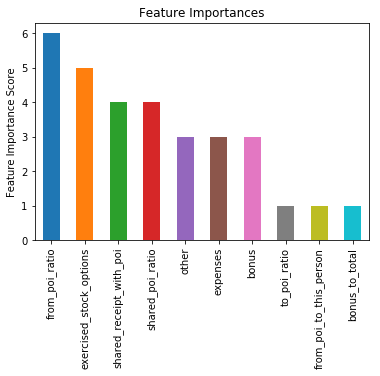

In [6]:
#Choose all features
features = [col for col in df_fixed]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_X, features, cv_folds=4)


Model Report
Accuracy : 0.9646
AUC Score (Train): 0.993846


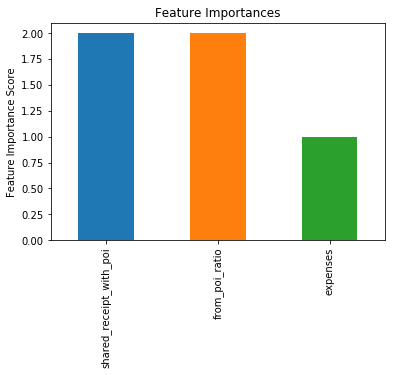

In [30]:
features = ['from_poi_ratio','exercised_stock_options', 'shared_poi_ratio', 'shared_receipt_with_poi', 'expenses', 'other']
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_X, features, cv_folds=4)

In [7]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_X,train_Y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.9516666666666665)

In [8]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_X,train_Y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 4}, 0.9533333333333334)

In [9]:
param_test2b = {
 'min_child_weight':[4,6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.9646
AUC Score (Train): 0.991538


({'min_child_weight': 4}, 0.9533333333333334)

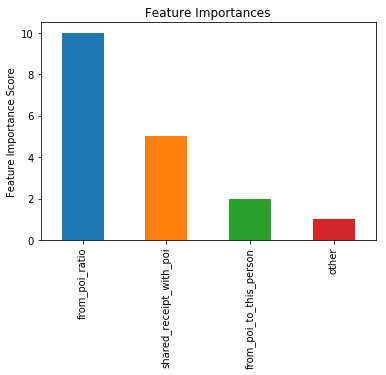

In [10]:
modelfit(gsearch2b.best_estimator_, train_X, features, cv_folds=4)
gsearch2b.best_params_, gsearch2b.best_score_

In [11]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_X,train_Y)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9533333333333334)


Model Report
Accuracy : 0.9646
AUC Score (Train): 0.991538


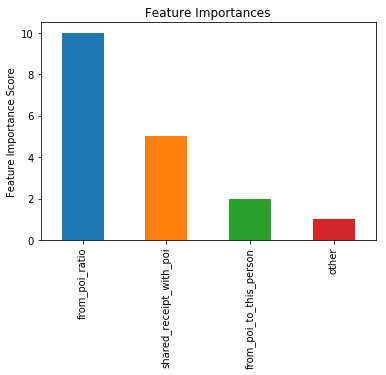

In [12]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_X, features, cv_folds=4)

In [15]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_X,train_Y)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9650000000000001)

In [19]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.85, 0.9, 0.95], 'colsample_bytree': [0.65, 0.7, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9650000000000001)

In [22]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.65,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_X,train_Y)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9650000000000001)


Model Report
Accuracy : 0.885
AUC Score (Train): 0.988846


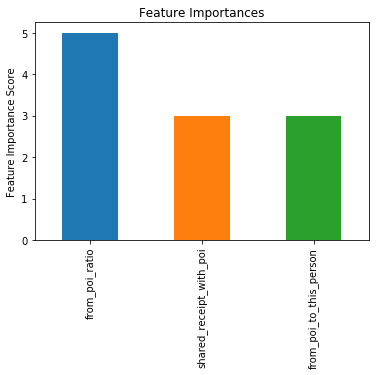

In [25]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.65,
 reg_alpha=0.00001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train_X, features, cv_folds=4)


Model Report
Accuracy : 0.885
AUC Score (Train): 0.986923


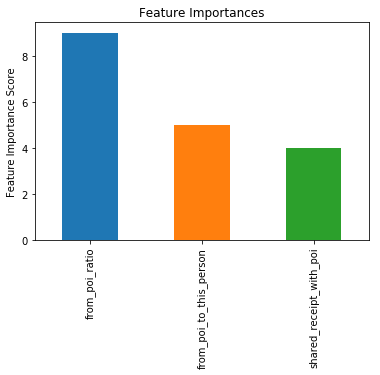

In [26]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.65,
 reg_alpha=0.00001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train_X, features, cv_folds=4)

In [28]:
xgb1.fit(train_X, train_Y)
pred = xgb1.predict_proba(test_X)[:, 1]
sub = pd.DataFrame({'name': names, 'poi': pred})
sub.to_csv('mid_tuned.csv', index=False)

In [29]:
xgb4.fit(train_X, train_Y)
pred = xgb4.predict_proba(test_X)[:, 1]
sub = pd.DataFrame({'name': names, 'poi': pred})
sub.to_csv('mid_tuned2.csv', index=False)